In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread

In [3]:
path='/Users/arvindramesh/Downloads/datascience/cell_images'

In [4]:
os.listdir(path)

['.DS_Store', 'test', 'train']

In [6]:
train=path+'/train'
test=path+'/test'

In [7]:
os.listdir(train)

['.DS_Store', 'parasitized', 'uninfected']

In [8]:
para=train+'/parasitized'

In [10]:
os.listdir(para)[0]

'C189P150ThinF_IMG_20151203_142224_cell_84.png'

In [11]:
para_cell=para+'/C189P150ThinF_IMG_20151203_142224_cell_84.png'

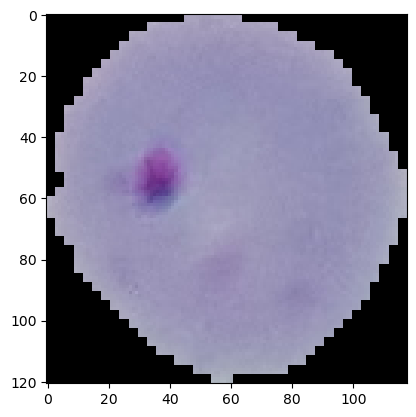

In [13]:
plt.imshow(imread(para_cell))

In [14]:
dim1=[]
dim2=[]
for img in os.listdir(test+'/uninfected'):
    image=imread(test+'/uninfected/'+img)
    d1,d2,c=image.shape
    dim1.append(d1)
    dim2.append(d2)

In [16]:
np.mean(dim1)

130.92538461538462

In [17]:
np.mean(dim2)

130.75

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
image_gen=ImageDataGenerator(rotation_range=20,horizontal_flip=True,zoom_range=0.1,shear_range=0.1,width_shift_range=0.1,height_shift_range=0.1,fill_mode='nearest')

In [20]:
train_images=image_gen.flow_from_directory(train,batch_size=32,target_size=[130,130],color_mode='rgb',class_mode='binary')
test_images=image_gen.flow_from_directory(test,batch_size=32,target_size=[130,130],color_mode='rgb',class_mode='binary')

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [24]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=[130,130,3], activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)      

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [29]:
results = model.fit_generator(train_images,epochs=20,
                              validation_data=test_images,
                             callbacks=[early_stop])

Epoch 1/20


/var/folders/cn/r_mvyq893c357lflld6x0pvw0000gn/T/ipykernel_94836/3842921389.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_images,epochs=20,
2023-04-13 22:07:17.235296: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 40/780 [>.............................] - ETA: 53s - loss: 14.5550 - accuracy: 0.5352

KeyboardInterrupt: 

In [30]:
from tensorflow.keras.models import load_model

In [31]:
model=load_model('malaria_detector.h5')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [35]:
model.evaluate_generator(test_images)

/var/folders/cn/r_mvyq893c357lflld6x0pvw0000gn/T/ipykernel_94836/1746724027.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_images)


[37.836978912353516, 0.8676922917366028]

In [51]:
from tensorflow.keras.preprocessing import image

In [38]:
pred_probabilities = model.predict_generator(test_images)

/var/folders/cn/r_mvyq893c357lflld6x0pvw0000gn/T/ipykernel_94836/635480963.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_probabilities = model.predict_generator(test_images)


In [42]:
predictions=(pred_probabilities>0.5).astype('int32')

In [44]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [45]:
print(classification_report(test_images.classes,predictions))

              precision    recall  f1-score   support

           0       0.51      0.62      0.56      1300
           1       0.52      0.42      0.46      1300

    accuracy                           0.52      2600
   macro avg       0.52      0.52      0.51      2600
weighted avg       0.52      0.52      0.51      2600



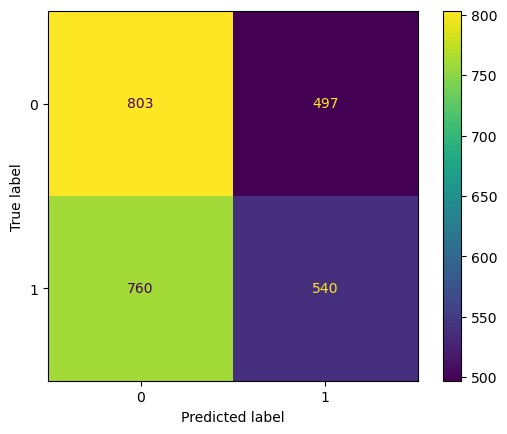

In [46]:
ConfusionMatrixDisplay.from_predictions(test_images.classes,predictions)

In [52]:
my_image = image.load_img(para_cell,target_size=[130,130,3])

In [54]:
my_image=image.img_to_array(my_image)

In [55]:
my_image=np.expand_dims(my_image,0)

In [57]:
(model.predict(my_image)>0.5).astype('int32')

1/1 [==============================] - 0s 13ms/step


array([[0]], dtype=int32)

In [58]:
train_images.class_indices

{'parasitized': 0, 'uninfected': 1}